Vincent Foriel\
24/12/2022

---

<div align=center>

# N-body simulation

</div>

---



# 1. Introduction

The aim of this project was to observe the increasing speed of a parallel program in function of the number of threads. To do so, we designed a program to simulate the behavior of N objects with a constant mass that interact gravitationally using the Leap Forg method. This simulation allow to have both iterative and parallelizable parts. In fact, there is an initialization and saving part that are not parallelizable, in addition to a main loop that iterate over the time, with each time step depending on the previous one. But in this main loop, we have to integrate the acceleration of each objects in function of the position of all the others. This part is parrallisable. The code was made in Fortran and the parallelization was done using OpenMP.

# 2. Creation of a program that work

In order to parallelise a code, we first need to have a working one. It actually doesn't really matter if the results are not physically meaningfull as long as the behavior of the program is coherent. However, as good physicists, we need to have revelant results. So we first designed a sequential program that can be represented as follow:

1. Initialisation of the objects
2. Loop over the time
    1. Loop over the objects i
        - Loop over all the other objects j
            - Compute the acceleration of the object i in function of the object j
    2. Saving the results

For the initialisation, I generate a random (homogeneous) position in a 1-radius sphere for each object and a tangential velocity along the {x,y} plane with a constant angular speed.

In order to be sure that the program gives a good result, I also computed the potential and kinetic energy to ensure having a constant total energy, as well as the barycenter to ensure that the center of mass is not moving. The results are shown in the following figure:

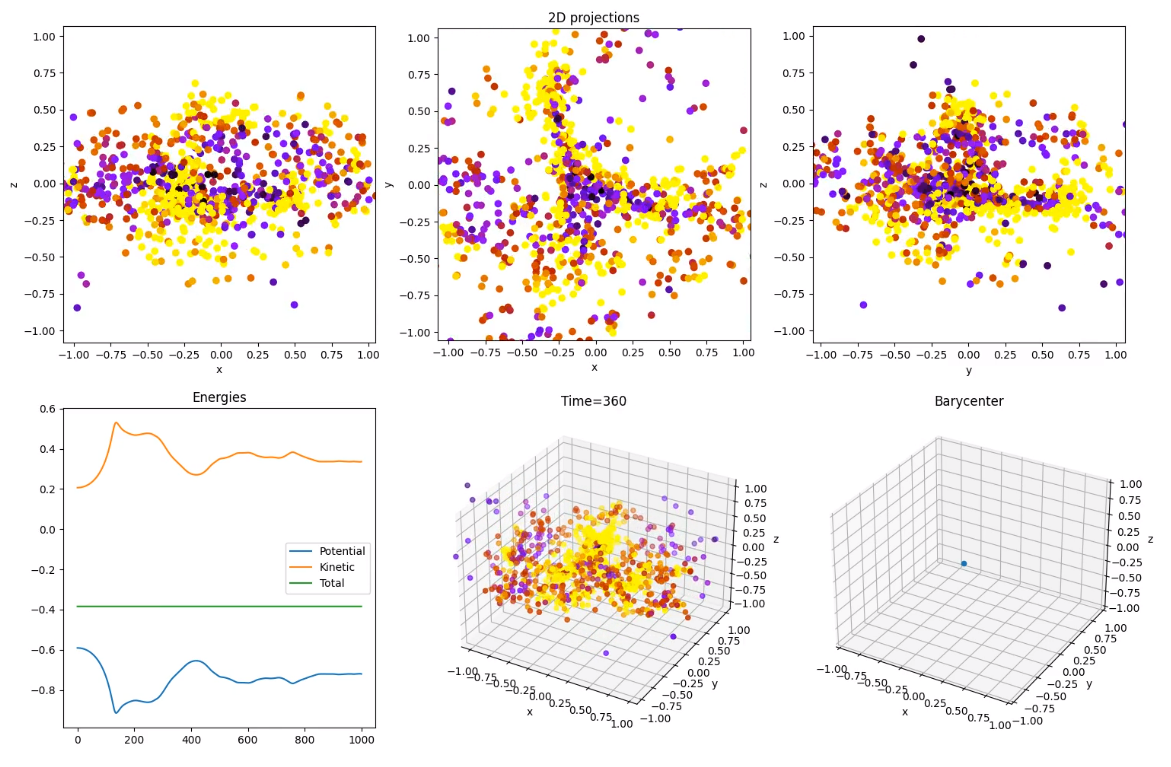

Here, the total energy is constant ✅ the barycenter is not moving (almost... as there is a forced minimal distance between the objects, it can move slightly) ✅ and visually, the objects are moving as we can expect ✅ (it is more obvious on the animated version of this plot). As it is not the main point of this project, I will consider it's enough to say that it's correct.

# 3. Parallelization

In a second time, I parallelized the part 2.1 of the program (see above). The parallelization is done using the commands:

```fortran
!$omp parallel reduction(+:Ep,ax,ay,az) private(dx,dy,dz,r,i,j) firstprivate(G,m,eps,x,y,z,N)
!$omp do schedule(guided)
```

Several things to say:

- The first command is used to define the parallel region, and the second one is used to define the loop that will be parallelized.
- The `reduction` is used to sum the resulting energy and acceleration computed on each thread.
- I put in `private` all the variables for which the value is proper to one thread in order to avoid conflicts between the threads and to have a better performance. Note that `i` is by default in private but I put it here for the sake of clarity.
- The `firstprivate` clause is used to define all the variable that are constant for all the threads, so the program will create a copy of these variables for each thread.
- The `schedule` is used to define the way the loop will be distributed between the threads. In this case, the guided schedule is used, which means that the loop will be be dichotomicly divided between the threads in order to have the best of both worlds: big chunks (so small number of thread initialization) and good load repartition (so no thread waiting for the others). This strategy was chosen because it is the one that gave the best performance over several tests.

# 4. Ensuring it still work

To ensure that the parallelization does not change the results, I looked at the energy, the barycenter and the visual evolution of the objects. The results is nearly the same, but as in the initialization we defined a random position for the objects, it is difficule to be more affirmative. For this reason, I saved the position of the object of one run, and I performed the next run using these initial positions. The results was exactly the same, so the parallelisation works! Or at least, it doesn't break the code.

# 5. Speedup

To see if it really works, I computed the speedup of the program in function of the number of threads. The results are shown in the following figure:

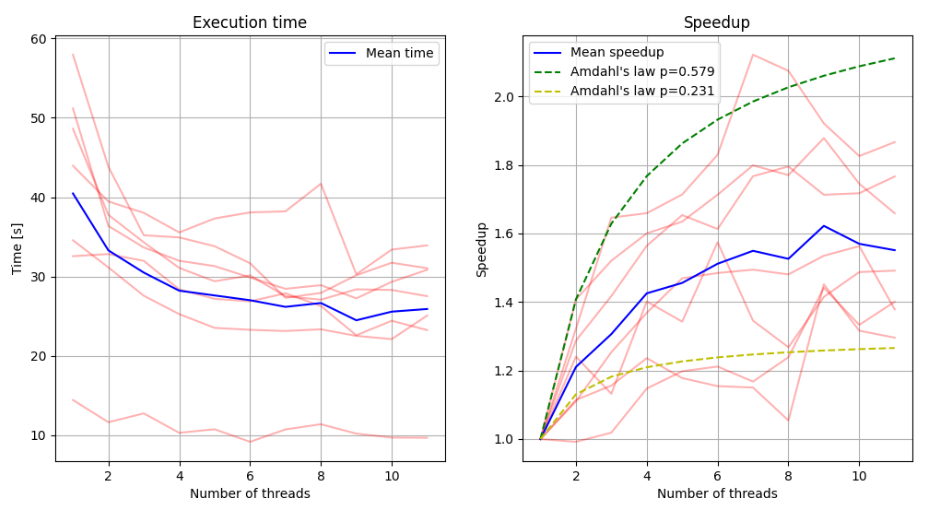

> Execution environment:
> - System: Ubuntu 22.04 WSL on Winsows 11
> - Processor: Intel core i7-1165G7 (4 cores 8 threads) at 2.8 GHz
> - RAM: 16 GB

By replacing the acceleration subroutine (which is the critical part that is parallelized) by a subroutine that does nothing, I can get a good approximation of the sequential time of the program. Using my computer with 10000 objects on 100 time steps, I got 15.99s instead of 38.016s with the normal acceleration function on one thread. This means that the parallel zone represent 57.9% of the total execution time. If I put 3000 objects on 1000 time steps, I get 71.565s instead of 93.075s, which means that the parallel zone represent 23.1% of the total execution time. I will consider these two results as the maximum and minimum of the percentage of the program that can be parallelized depending of the parameters (and then put the same order of magnitude for the parameters for the others simulations).

This, I can compute the theoritical speedup using the Amdahl Law:

$$
Speedup = \frac{1}{1 - p + \frac{p}{n}}
$$

With
- $p$ the percentage of the program that can be parallelized (here 57.9% or 23.1%)
- $n$ the number of threads

We see on the plot above that the speedup is globally included into these two bounds. This means that the parallelization works as expected! However we can also see that each iteration (in red) flucuate a lot, which makes sense because the computer is doing several other things at the same time, but the average gives us the tendency of the speedup which is in between of the two bounds.

# 6. Optimizing the complexity

Looking at how the parallelization increase the program is nice, but another very powerful way to reduce the computation time is to find alternative algorithms that reduce the complexity. Here, the algorithm have a complexity of about $N^2$ ($N(N-1)$ to be exact) because for each particule, we have to compute the acceleration with the $N-1$ other particules, which result in $N^2$ computations of the critical part of the program.

Here, the algorithm used is Leap-Frog, but it existe a lot of other algorithms such as the Barnes Hut that have a smaller complexity: `N*log(N)`. It is not the scope of this project to implement one of these algorithms. However, there is a way to optimize the Leap Forg algorithm by using the fact that the acceleration of the object `i` induced by the object `j` is the same as the acceleration of the object `j` induced by the object `i`. This way, we can reduce the complexity to $\frac{N(N-1)}{2}$.

For the same parameters, this optimisation allow to reduce the computation time from 51.2s to 32.6s with one thread, and from 28.9s to 26.3s with 8 threads (the maximum number of threads on my computer). This complexity reduction is then a good thing to do to optimize the program for processors that have not a lot of cores.

# 7. Optimizing the parallelization

The interesting thing is that in a such optimized Leap Frog, the inner loop doesn't have anymore a constant number of iterations. That means that we have to verify that our strategy of dispatching the loop between the threads is still the best one. In practice, the best strategy is still the guided one, which makes more sens in this case than in the previous one. Before we was expecting to have better performances using static repartition as all the iterations was the same. But as we are dealing with a lot of objects (so a lot of iterations) on a computer that is not fully dedicated to this computation, some thread probably get late. That should explain why the guided strategy was already the best one.

# 8. Conclusion

This project allowed to handle the parallelisation process and showed the benefits of parallelisation, but also the limits. In fact, even with 8 cores, the speedup goes up to 2.5 times the sequential version. This is less that what we can expect in a first place, so it's not a magical solution. Reducing the complexity of the algorithm, using a low-level language with optimisation compilation flags and using a dedicated computer are also very important to make high performance computations.